# Formación de sintagmas

*********************************************

Variables:

$w=[w_1, ..., w_n] \rightarrow$ El sintagma

* $e_t \in \{0,1\} \rightarrow$ Ocurrencia del evento en el momento $t$
* $s_t \in \{0,1\} \rightarrow$ Existencia de la situación en el momento $t$
* $s_{t-1} \rightarrow$ Situación en el momento $t-1$
* $w_t^i \rightarrow$ El evento del sintagma siendo formado en el momento $t$:
    * $i=0$: hipótesis de que el sintagma no se ha formado aún
    * $i=1$: hipótesis de que el sintagma se ha formado
* $\pi_t \rightarrow$ Observación

\begin{matrix}
    \pi^1 = \left\{
        \begin{matrix} 
            \frac{n(w_1...w_n)}{max(n(w_1), ..., n(w_n))} & if\ \max(n(w_1), ..., n(w_n)) > 0
                \\
            0 & otherwise 
        \end{matrix}\right.
    \\
    \pi^0=1-\pi^1
\end{matrix}

**La calidad *q* del sintagma no se va a tener en cuenta**


*********************************************

* $\alpha_j^i(t)=P[w_t=i|s_t=j]$

* $\beta_{kh}^j(t)=P[s_t=j|s_{t-1}=k,e_t=h]$

* $\nu^k(t)=P[s_{t-1}=k]$

* $\gamma^h(t)=P[e_t=h]$

* $\tau_i^{jkh}=P(s_t=j,s_{t-1}=k, e_t=h|w=i)$

$i, j, k, h \in \{0,1\}$

*********************************************

In [ ]:
years = list()
months = list()

years.extend(LAST_DECADE)
months.extend(ALL_MONTHS)

syntagm = "lock down"

count_individual_words = dict()
split = syntagm.split(" ")

for year in years:
    for month in months:

        count_syntagm = 0

        for word in split:
            count_individual_words[word] = 0

        path = DATA_PATH + str(year) + "/" + str(month) + EXT

        with open(path, "r") as f:

            docs = json.loads(f.read())[DATA]

            for i, doc in enumerate(docs):

                abstract = doc[ABSTRACT]
                snippet = doc[SNIPPET]
                lead = doc[LEAD_PAR]

                count_syntagm += abstract.count(syntagm) + \
                    snippet.count(syntagm) + lead.count(syntagm)

                for word in count_individual_words:
                    regex = fr"\b{word}\b"

                    num_abstract = len(re.findall(regex, abstract, re.IGNORECASE))
                    num_snippet = len(re.findall(regex, snippet, re.IGNORECASE))
                    num_lead = len(re.findall(regex, lead, re.IGNORECASE))

                    count_individual_words[word] += num_abstract + num_snippet + num_lead


        if count_syntagm != 0:
            print(f"Numero de veces que aparece el sintagma entero'{syntagm}' en {year}/{month} --> {count_syntagm}", end="")
        print(f"\t {count_individual_words}")

Consideraciones previas:

- La situación no se ha dado en $t=0$
    - $\nu^0(t)=1$
    - $\nu^1(t)=0$

- $\psi$: lista que, para cada t, contiene la probabilidad de que el evento que causa el sintagma se genere

- $\alpha, \beta, \nu, \gamma$ son listas de:

    - n listas, siendo n el subíndice:
        - cada lista de m posiciones según el superíndice.



- $\alpha$: [[ , ], [ , ]]
- $\beta$: [[ [ , ] , [ , ] ], [ [ , ] , [ , ] ]]
- $\nu$: una lista de dos posiciones
- $\gamma$: una lista de dos posiciones

- $\tau$: ocho listas de dos posiciones

In [63]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

EXT = ".json"

ALL_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
LAST_DECADE = [2019, 2020, 2021, 2022, 2023]

DATA_PATH = "data/"

# Elementos importantes de los articulo
RESPONSE = "response"
DOCS = "docs"
DATA = "data"

ABSTRACT = "abstract"
SNIPPET = "snippet"
LEAD_PAR = "lead_paragraph"
PUB_DATE = "pub_date"

# Para la grafica
YEAR = "year"
MONTH = "month"
VALUE = "value"

In [64]:
def plotData(data, syntagm):

    # Crear un DataFrame
    df = pd.DataFrame(data)

    # Crear una columna de fecha combinando año y mes
    df[PUB_DATE] = pd.to_datetime(df[[YEAR, MONTH]].assign(day=1))

    # Establecer PUB_DATE como el índice del DataFrame
    df.set_index(PUB_DATE, inplace=True)

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[VALUE], marker='o')

    # Formatear el eje X para mostrar año y mes
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))  # Etiquetas cada 6 meses

    # Rotar las etiquetas del eje X para mejor legibilidad
    plt.gcf().autofmt_xdate(rotation=15)

    # Añadir etiquetas y título
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(syntagm)

    # Mostrar la gráfica
    plt.grid(True)
    plt.show()

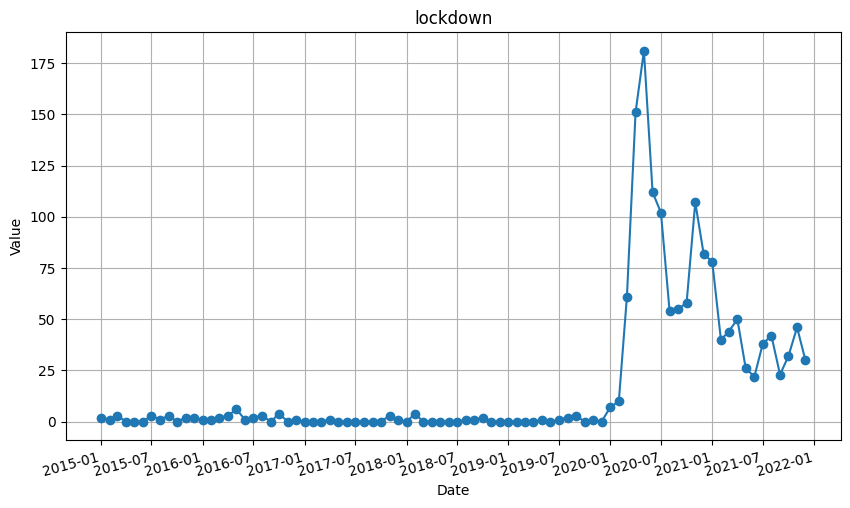

In [65]:
def computePi(year, month, syntagm):

    # contador para las apariciones del sintagma completo
    count_syntagm = 0

    # diccionario contador para las apariciones de cada una de las palabras
    split = syntagm.split(" ")
    count_individual_words = dict()

    if len(split) > 1:
        for word in split:
            count_individual_words[word] = 0

    # ruta al json de datos
    path = DATA_PATH + str(year) + "/" + str(month) + EXT

    with open(path, "r") as f:

        # cargamos el json en memoria
        docs = json.loads(f.read())[DATA]

        for doc in docs:

            abstract = doc[ABSTRACT]
            snippet = doc[SNIPPET]
            lead = doc[LEAD_PAR]

            regex = fr"\b{syntagm}\b"

            num_abstract = len(re.findall(regex, abstract, re.IGNORECASE))
            num_snippet = len(re.findall(regex, snippet, re.IGNORECASE))
            num_lead = len(re.findall(regex, lead, re.IGNORECASE))

            # contamos el numero de apariciones del sintagma completo
            count_syntagm += num_abstract + num_snippet + num_lead

            if len(split) > 1:

                # contamos el numero de apariciones de cada termino del sintagma
                # mediante una expresion regular
                for word in count_individual_words:
                    regex = fr"\b{word}\b"

                    num_abstract = len(re.findall(regex, abstract, re.IGNORECASE))
                    num_snippet = len(re.findall(regex, snippet, re.IGNORECASE))
                    num_lead = len(re.findall(regex, lead, re.IGNORECASE))

                    count_individual_words[word] += num_abstract + num_snippet + num_lead

    if len(split) > 1:
        return [count_syntagm, max(count_individual_words.values())]
    else:
        return [count_syntagm, count_syntagm]


syntagm = "lockdown"

data = dict()

data[YEAR] = list()
data[MONTH] = list()
data[VALUE] = list()

for i in range(2015, 2022):
    for j in range(1, 13):

        data[YEAR].append(i)
        data[MONTH].append(j)

        pi = computePi(i, j, syntagm)

        data[VALUE].append(pi[0])

plotData(data, syntagm)

In [66]:
beta = np.random.rand(2, 2, 2)
# print("\nbeta:")
# print("\n", beta)

gamma = np.random.rand(2)
print("\ngamma:")
print("\n", gamma)

pi = np.random.dirichlet(np.ones(2))
print("\n--> pi:")
print("\n", pi)

tau = np.random.rand(2, 2, 2, 2)
# print("\ntau:")
# print("\n", tau)

alpha = np.random.rand(2, 2)
# print("\n--> alpha:")
# print("\n", alpha)

nu = np.array([1, 0])
print(nu)

print("\n------------------------------------------\n")


def computeAlpha(alpha, tau):

    for i, level_zero in enumerate(alpha):
        for j, _ in enumerate(level_zero):

            numerador = pi[i] * tau[i][j].sum()

            alpha[i][j] = numerador

    return alpha


def computeBeta(beta, tau):

    for i, level_zero in enumerate(beta):
        for j, level_one in enumerate(level_zero):
            for k, _ in enumerate(level_one):

                numerador = 0
                for h, _ in enumerate(pi):
                    numerador += pi[h] * tau[i][j][k][h]

                beta[i][j][k] = numerador

    return beta


def computeGamma(gamma, tau):

    for i, _ in enumerate(gamma):

        numerador = 0
        for j, level_one in enumerate(tau):
            for k, level_two in enumerate(level_one):
                for h, _ in enumerate(level_two):
                    numerador += pi[j] * tau[i][j][k][h]

        gamma[i] = numerador

    return gamma


def computeTau(tau, alpha, beta, nu, gamma, t):

    for i, level_zero in enumerate(tau):
        for j, level_one in enumerate(level_zero):
            for k, level_two in enumerate(level_one):
                for h, _ in enumerate(level_two):

                    numerador = alpha[i][j] * beta[j][k][h] * \
                        nu[k] * (t - 1) * gamma[h]
                    tau[i][j][k][h] = numerador
    return tau


times = 10
for t in range(2, times):

    tau = computeTau(tau, alpha, beta, nu, gamma, t)
    alpha = computeAlpha(alpha, tau)
    beta = computeBeta(beta, tau)
    gamma = computeGamma(gamma, tau)


gamma:

 [0.54109001 0.71913964]

--> pi:

 [0.45403614 0.54596386]
[1 0]

------------------------------------------



TypeError: computeTau() missing 4 required positional arguments: 'beta', 'nu', 'gamma', and 't'